Assignment 11
==============
Name : Nihar Kanungo Batch : 6:30 AM , Sunday

# Background :

This is a Image Recognition program which makes use of the Cifar 10 preprocessed dataset . The Code uses one of the most popular Tensorflow API Keras to perform the operations .It's a supervised Computer Vision problem. 

This assignment is to find out the 

1. Optimal Learning Rate for a model 
2. Train the Network using the Optimal Learning Rate 
3. Use Mini Batch Gradient Descent (popularly known as SGD) with Momentum while training the network 
4. Find out 25 Misclassified Images as predicted by the Network (The Predicted and Actual Labels for differentiation )
5. Run Gradcam on the misclassfied images (Last layer and last layer-1 th layer )

Input
1) 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values

Environment

Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm
Sequential Model with Dropout, Batch Normalization etc.

Conditions
The Model should use the Optimal Learning Rate , SGD with Momentum to predict 

#Import all Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras import regularizers

#Load the CIFAR 10 images into the notebook 
The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10. CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images.

Source : wikipedia

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

# Display the shape of the data

In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


# Display the Class outputs

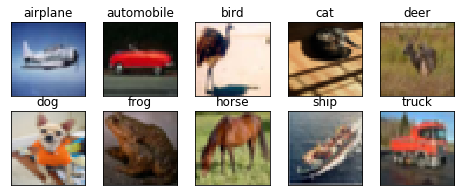

In [20]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#Function to define the Model history and Plot chart
The Parameters of the model is a key information to quickly visualize how the model performed . Analysis of the

Training Accuracy vs Validation Accuracy and

Training Loss vs Validation Loss

would give a great understanding of the model performance

Writing a custom function helps us to modify or customize the information based on our need. We are building these functions so that we can customize more in future

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#Function to define the Accuracy of the model
This custom function will help us i future to design the Accuracy based on our need

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Standardize the data by diving it by 255

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# One hot encoding of the Output variable

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Operations 
1. Define Image Normalization 
2. Define Iterator for Train 
3. Calculate Batch Statistics 
4. Display batch statistics

In [22]:
# load dataset
#(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (train_features.mean(), train_features.std(), test_features.mean(), test_features.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(train_features)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(train_features, train_labels, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=0.473 (0.252), test=0.477 (0.251)
(128, 32, 32, 3) 0.017879589 1.0062418
(50000, 32, 32, 3) -2.1983838e-06 0.9999975


#Operations

Define Iterator for Test Data

In [0]:
iterator1 = datagen.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
#Y_train = np_utils.to_categorical(y_train, 10)
#Y_test = np_utils.to_categorical(y_test, 10)

# Define the Random Eraser (Cutout) Function to be used 
For More information on Random Eraser/cutout - Please see Assignment 9 where this topic has been discussed in depth

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        #mean_img = np.mean(input_img, axis =(0,1)) 
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# Define the LR Finder Function 

The idea behind finding this Learning rate is to 

1. Start with a very small learning rate (e.g. 1e-10) and exponentially increase the learning rate with each training step.
2. Train your network as normal
3. Record the training loss and continue until you see the training loss grow rapidly
4. Stop the network there and find the optimal learning rate using the LR where the loss is minimum, infact we want find the section where loss is decreasing fastest, and use the learning rate that was being used at that training step.
5. Smoothen the curve for visibility 


In [0]:
from keras.callbacks import Callback
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        min_loss_index = self.losses.index(min(self.losses))
        print(self.lrs[min_loss_index])
        
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

# Define the Model to be trained . This model will use the Learning Rate which is found using the LR finder function 

Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In machine learning, we use gradient descent to update the parameters of our model. Parameters refer to coefficients in Linear Regression and weights in neural networks.

#Learning rate

![](images/lr_graph.jpeg)

The size of these steps is called the learning rate. With a high learning rate we can cover more ground each step, but we risk overshooting the lowest point since the slope of the hill is constantly changing. With a very low learning rate, we can confidently move in the direction of the negative gradient since we are recalculating it so frequently. A low learning rate is more precise, but calculating the gradient is time-consuming, so it will take us a very long time to get to the bottom.

# SGD with Momentum

![](images/mt.jpeg)

![](images/nesterov.jpeg)

![](images/momentum.png)

![](images/nest.png)


Mini-batch gradient descent makes a parameter update with just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will “oscillate” toward convergence. Gradient Descent with Momentum considers the past gradients to smooth out the update. It computes an exponentially weighted average of your gradients, and then use that gradient to update your weights instead. It works faster than the standard gradient descent algorithm

In [25]:
from keras import optimizers
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))

# Compile the model
#sgd = optimizers.SGD(lr=0.019917404182918062)
sgd = optimizers.SGD(lr=0.019917404182918062, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = sgd(lr=)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regulariz

# Print Model Summary

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

# Run the Model using the LR Finder function 
Here we took the lower bound and upper bound for the learning rate and fit the model to find out the optimal learning rate 

In [15]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/128))
model.fit(X_train, y_train, epochs=5,callbacks=[lr_finder] )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
11552/50000 [=====>........................] - ETA: 59s - loss: 3.6408 - acc: 0.2028

# Print the LR vs Loss function graph
It also prints the optimal learning rate 

0.019917404182918062


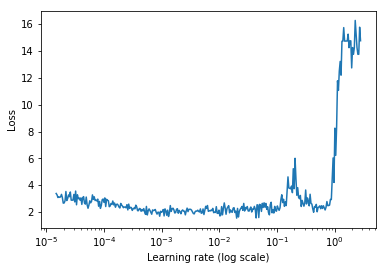

In [16]:
lr_finder.plot()

### Total params: 455,370

# Train the Model using the Optimal Learning Rate , SGD with momentum 

This model also includes cutout, Batch Normalization and Dropout 
Model was run for 100 epochs
Verbose =0 option was choosen ( NO logs are printed and training is slightly faster due to this )
Prints the Top accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, steps_per_epoch=390, epochs=100)`
  del sys.path[0]


Model took 2533.49 seconds to train


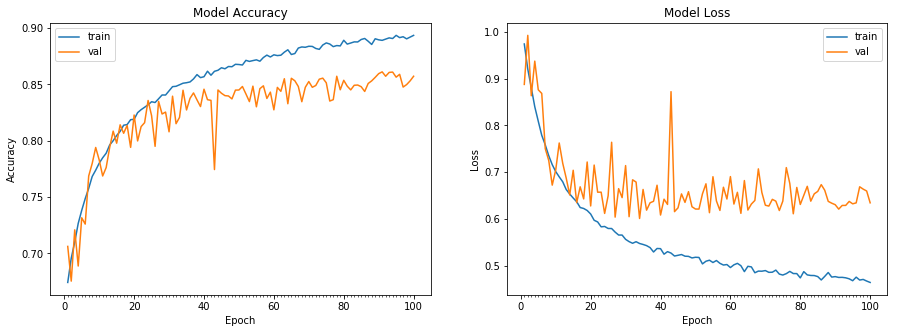

The Top Accuracy is  0.8611
Accuracy on test data is: 85.72


In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=True), 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100,  
                                 validation_data = (X_test, y_test), verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
top_val_acc=model_info.history['val_acc']
print("The Top Accuracy is ", max(top_val_acc))
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, y_test, model))

# Display the 25 misclassified images on which we will run gradcam 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

no of misclassified images are 25


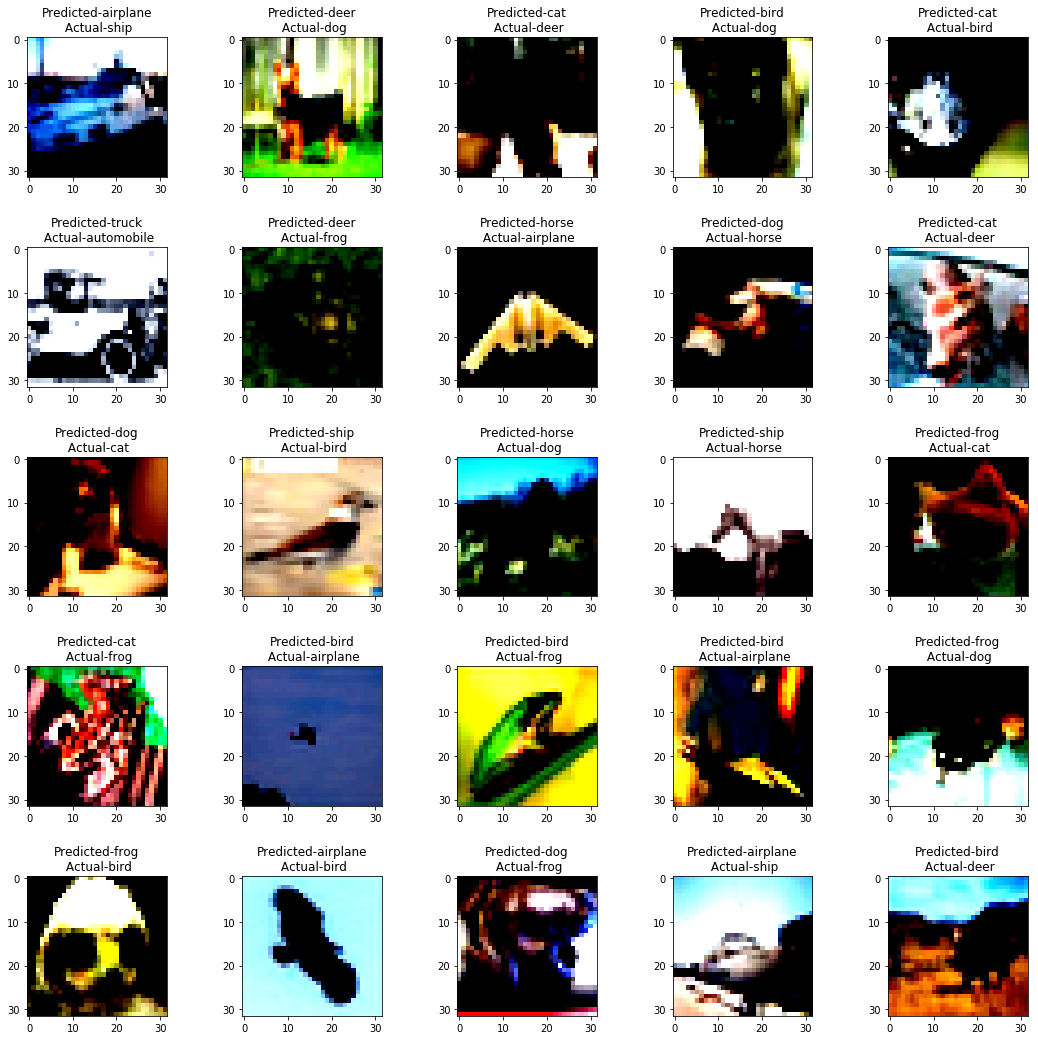

In [34]:
count =0 
fig=plt.figure(figsize=(18, 18))
image_no_for_next = []
for img_num in range(len(y_test)):
  if count ==25:
    break
  x = np.expand_dims(X_test[img_num], axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  if class_idx != np.argmax(y_test[img_num]):
    
#     print('predicted',class_idx)
#     print('Actual ',np.argmax(train_labels[img_num]))
    image_no_for_next.append(img_num)
    ax = fig.add_subplot(5, 5, count+1)
    plt.imshow(X_test[img_num])
    ax.set_title("Predicted-" + class_names[class_idx] + '\n'+" Actual-" + class_names[(np.argmax(y_test[img_num]))])
    count = count +1 
print('no of misclassified images are', count)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()
  
# class_output = model.output[:, class_idx]
# last_conv_layer = model.get_layer("block5_conv3")

# Import other required libraries 

In [0]:
#from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
#from keras.preprocessing import image
import keras.backend as K
#import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import sys

# Run the Gradcam on the Misclassified images

(For details on how gradcam works please refer Assignment 9 & 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

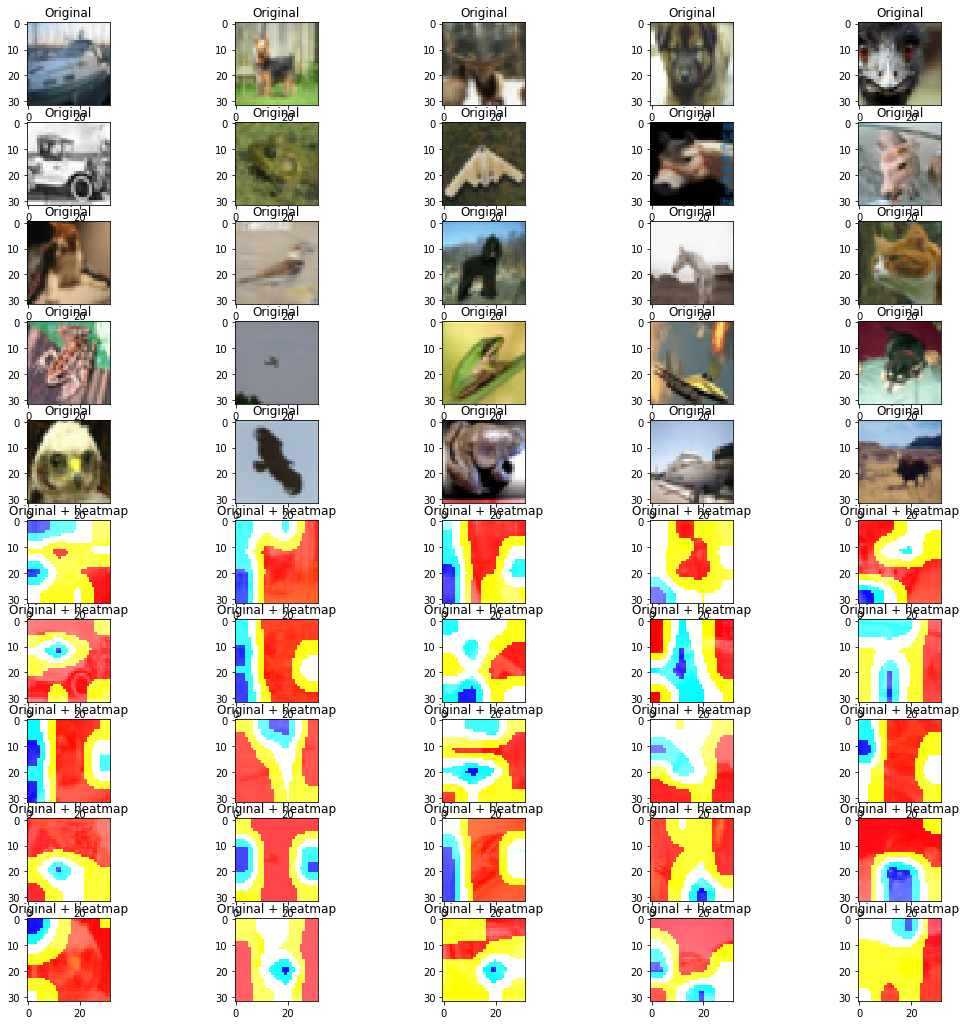

In [40]:
#import cv2
random_imgs = image_no_for_next

orig_imgs = []
mod_imgs = []
heat_imgs = []

for img_idx in random_imgs:
  x = np.expand_dims(test_features[img_idx], axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_18")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
  img = test_features[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = heatmap*0.5+img * 0.5
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.2, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  orig_imgs.append(img)
  mod_imgs.append(superimposed_img)
  heat_imgs.append(heatmap)
  cv2.waitKey(0)

img_list = orig_imgs + mod_imgs + heat_imgs

# settings
h, w = 5, 5       # for raster image
nrows, ncols = 10, 5  # array of sub-plots
figsize = [18,18]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
  if i < 25:
      
    axi.set_title("Original")
#   elif i <10 :
#     axi.set_title("Original + heatmap")
  else:
    axi.set_title("Original + heatmap")

  axi.imshow(img_list[i])


# Run Gradcam on the last-1 th Layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

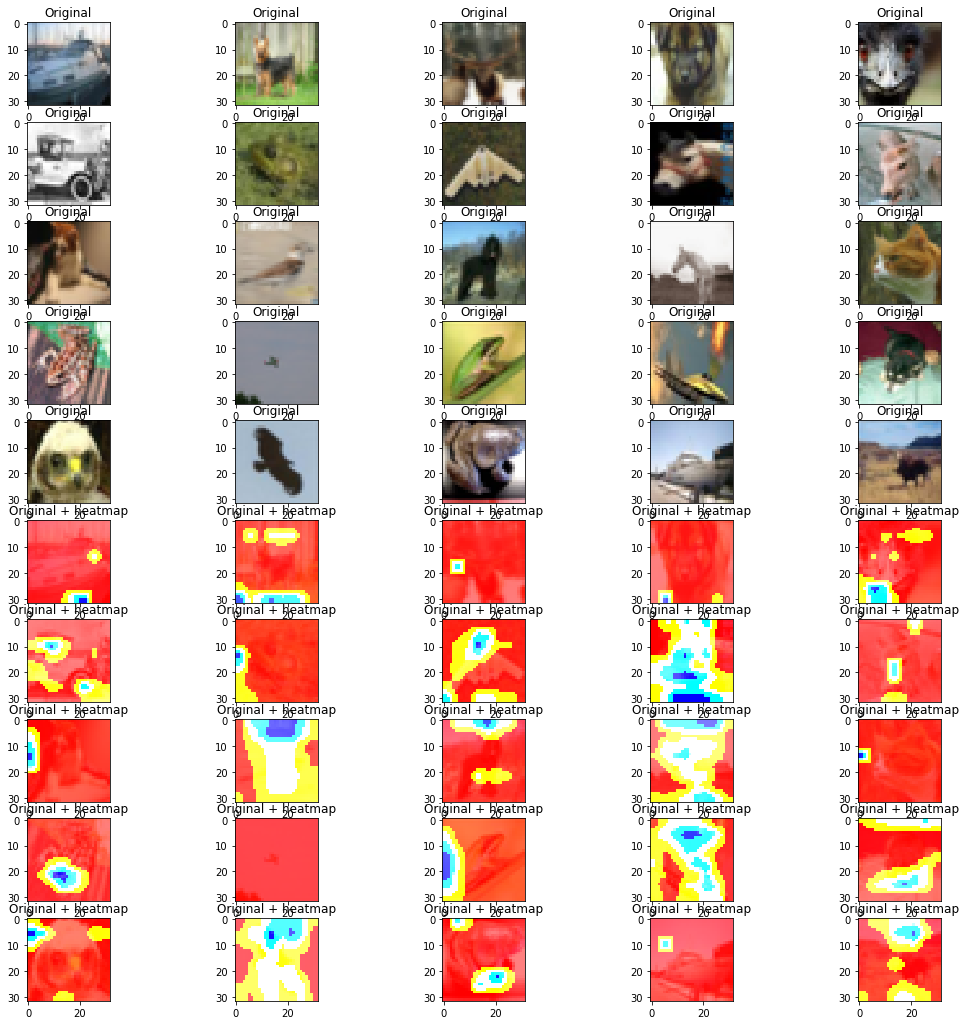

In [41]:
#import cv2
random_imgs = image_no_for_next

orig_imgs = []
mod_imgs = []
heat_imgs = []

for img_idx in random_imgs:
  x = np.expand_dims(test_features[img_idx], axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_17")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
  img = test_features[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = heatmap*0.5+img * 0.5
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.2, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  orig_imgs.append(img)
  mod_imgs.append(superimposed_img)
  heat_imgs.append(heatmap)
  cv2.waitKey(0)

img_list = orig_imgs + mod_imgs + heat_imgs

# settings
h, w = 12, 12       # for raster image
nrows, ncols = 10, 5  # array of sub-plots
figsize = [18,18]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
  if i < 25:
      
    axi.set_title("Original")
#   elif i <10 :
#     axi.set_title("Original + heatmap")
  else:
    axi.set_title("Original + heatmap")

  axi.imshow(img_list[i])
